# Steering Hallucinations in Language Models: Extending the Linear Representation Hypothesis with Sparse Autoencoders and Transcoders

This notebook contains code for visualising steered vs unsteered GPT-2 Small outputs on LAMBADA prompts.  Please run SAE_Hallucination_Interpretability.ipynb to generate the list of top-ranked hallucination-causing features.  Paste this list below to save runtime (so the same calculations generating the feature ranking don't have to be run again).

## Setup

### Environment Setup

**Note**: Be sure to switch runtime to use a GPU for faster compute (e.g. T4 GPU).  If you have access to a high-RAM GPU (i.e. if you have Colab Pro), switching to use it will enable much better performance and allow for faster calculations

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
HIGH_RAM = True

if ram_gb < 20:
  HIGH_RAM = False
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [2]:
!pip install transformer_lens
!pip install circuitsvis
!pip install sae-lens
!pip install pandas
!pip uninstall -y numpy
!pip install numpy==1.26.4 # Newer numpy versions have dependency conflicts with pandas
# Install a faster Node version
!curl -fsSL https://deb.nodesource.com/setup_21.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
2025-05-11 23:11:25 - Installing pre-requisites
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://deb.nodesource.com/node_21.x nodistro InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 h

### Imports

**Important Note**: Sometimes numpy fails to use the specified version (v1.26.4) after being imported, which causes an error when importing the rest of the libraries due to dependency conflicts.  If the following doesn't print '1.26.4', then restart session via: 'Runtime' --> 'Restart Session' to fix the issue.

In [3]:
import numpy as np
print(np.__version__) # Should be 1.26.4
assert np.__version__ == '1.26.4'

1.26.4


The above block should have printed '1.26.4'.  If not, then restart session via 'Runtime' --> 'Restart Session'.  Else, continue.


In [4]:
import torch
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from datasets import load_dataset
import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer
from sae_lens import SAE

### PyTorch Setup

In [5]:
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


### Model and Dataset Import

In [6]:
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained("gpt2-small")
model.eval()

# Get the default device used
device: torch.device = utils.get_device()
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

In [7]:
lambada = load_dataset("lambada", split="test")

# Inspect a sample problem
example_prompt, example_answer = lambada[0]['text'].rsplit(' ', 1)
print('Question: ' + example_prompt + '\n')
print('Answer: ' + example_answer)

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

Question: in my palm is a clear stone , and inside it is a small ivory statuette . a guardian angel . `` figured if you 're going to be out at night getting hit by cars , you might as well have some backup . '' i look at him , feeling stunned . like this is some sort of sign . but as i stare at harlin , his mouth curved in a confident grin , i do n't care about

Answer: signs


We verify that our model can 'do' a task from this (LAMBADA) dataset (note that not all tasks may pass; we just want to verify that the model can do at least one of the tasks):

In [8]:
example_prompt, example_answer = lambada[8]['text'].rsplit(' ', 1)
utils.test_prompt(example_prompt, example_answer, model, print_details=True, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '``', ' why', ' ?', " ''", ' ``', ' i', ' would', ' have', ' thought', ' you', " '", 'd', ' find', ' him', ' rather', ' dry', ' ,', " ''", ' she', ' said', ' .', ' ``', ' i', ' do', ' n', "'t", ' know', ' about', ' that', ' ,', " ''", ' said', ' g', 'ab', 'riel', ' .', ' ``', ' he', ' was', ' a', ' great', ' crafts', 'man', ' ,', " ''", ' said', ' he', 'ather', ' .', ' ``', ' that', ' he', ' was', ' ,', " ''", ' said', ' fl', 'an', 'nery', ' .', ' ``', ' and', ' polish', ' ,', ' to', ' boot', ' ,', " ''", ' said']
Tokenized answer: [' g', 'ab', 'riel']


Performance on answer token:
Rank: 0        Logit: 12.41 Prob:  6.08% Token: | g|

Top 0th token. Logit: 12.41 Prob:  6.08% Token: | g|
Top 1th token. Logit: 12.26 Prob:  5.24% Token: | he|
Top 2th token. Logit: 11.55 Prob:  2.57% Token: | j|
Top 3th token. Logit: 11.44 Prob:  2.31% Token: | m|
Top 4th token. Logit: 11.37 Prob:  2.16% Token: | l|
Top 5th token. Logit: 11.22 Prob:  1.86% Token: | the|
Top 6th token. Logit: 11.17 Prob:  1.77% Token: | she|
Top 7th token. Logit: 11.07 Prob:  1.60% Token: | b|
Top 8th token. Logit: 11.04 Prob:  1.55% Token: | d|
Top 9th token. Logit: 11.00 Prob:  1.50% Token: | t|


Performance on answer token:
Rank: 0        Logit: 20.36 Prob: 89.14% Token: |ab|

Top 0th token. Logit: 20.36 Prob: 89.14% Token: |ab|
Top 1th token. Logit: 15.36 Prob:  0.60% Token: |abby|
Top 2th token. Logit: 14.62 Prob:  0.29% Token: |az|
Top 3th token. Logit: 14.30 Prob:  0.21% Token: |ordon|
Top 4th token. Logit: 14.19 Prob:  0.19% Token: |ib|
Top 5th token. Logit: 14.15 Prob:  0.18% Token: |im|
Top 6th token. Logit: 14.10 Prob:  0.17% Token: |har|
Top 7th token. Logit: 14.00 Prob:  0.15% Token: |abe|
Top 8th token. Logit: 13.89 Prob:  0.14% Token: |abb|
Top 9th token. Logit: 13.86 Prob:  0.13% Token: |ag|


Performance on answer token:
Rank: 0        Logit: 21.65 Prob: 99.19% Token: |riel|

Top 0th token. Logit: 21.65 Prob: 99.19% Token: |riel|
Top 1th token. Logit: 14.42 Prob:  0.07% Token: |ri|
Top 2th token. Logit: 14.08 Prob:  0.05% Token: |ry|
Top 3th token. Logit: 13.78 Prob:  0.04% Token: |rie|
Top 4th token. Logit: 13.73 Prob:  0.04% Token: |rin|
Top 5th token. Logit: 13.61 Prob:  0.03% Token: |rier|
Top 6th token. Logit: 13.60 Prob:  0.03% Token: |rian|
Top 7th token. Logit: 13.31 Prob:  0.02% Token: |ric|
Top 8th token. Logit: 13.03 Prob:  0.02% Token: |rius|
Top 9th token. Logit: 12.98 Prob:  0.02% Token: |ril|


Ranks of the answer tokens: [(' g', 0), ('ab', 0), ('riel', 0)]

### Model Accuracy Calculation

In [9]:
# Note: Code from function test_prompt() in the
# [TransformerLens Library](https://github.com/TransformerLensOrg/TransformerLens/blob/main/transformer_lens/utils.py)
def get_out_tokens(prompt, answer, model):

  answers = [answer] if isinstance(answer, str) else answer
  n_answers = len(answers)
  using_multiple_answers = n_answers > 1

  answers = [answer if answer.startswith(" ") else " " + answer for answer in answers]

  # GPT-2 often treats the first token weirdly, so lets give it a resting position
  prompt_tokens = model.to_tokens(prompt, prepend_bos=True)
  answer_tokens = model.to_tokens(answers, prepend_bos=False)

  # If we have multiple answers, we're only allowed a single token generation
  if using_multiple_answers:
    answer_tokens = answer_tokens[:, :1]

  # Deal with case where answers is a list of strings
  prompt_tokens = prompt_tokens.repeat(answer_tokens.shape[0], 1)
  tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)

  prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=True)
  answer_str_tokens_list = [model.to_str_tokens(answer, prepend_bos=False) for answer in answers]

  prompt_length = len(prompt_str_tokens)
  answer_length = 1 if using_multiple_answers else len(answer_str_tokens_list[0])

  logits = model(tokens)
  probs = logits.softmax(dim=-1)
  answer_ranks = []

  for index in range(prompt_length, prompt_length + answer_length):
    # Get answer tokens for this sequence position
    answer_tokens = tokens[:, index]
    answer_str_tokens = [a[index - prompt_length] for a in answer_str_tokens_list]

    # Offset by 1 because models predict the NEXT token
    token_probs = probs[:, index - 1]
    sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)
    answer_token_ranks = sorted_token_positions.argsort(-1)[
      range(n_answers), answer_tokens.cpu()
    ].tolist()
    answer_ranks.append(
      [
        (answer_str_token, answer_token_rank)
          for answer_str_token, answer_token_rank in zip(
            answer_str_tokens, answer_token_ranks
          )
      ]
    )

  # If n_answers = 1 then unwrap answer ranks, so printed output matches original version of function
  if not using_multiple_answers:
    single_answer_ranks = [r[0] for r in answer_ranks]
    return single_answer_ranks
  else:
    return answer_ranks


def is_correct(out_tokens):
  for pair in out_tokens:
    if pair[1] != 0:
      return False, pair[1]
  return True, pair[1]


def is_prediction_correct(prompt, answer, model):
  out_tokens = get_out_tokens(prompt, answer, model)
  return is_correct(out_tokens)


def calc_accuracy(data, model, dataset_name='lambada'):
  correct = 0
  results = []

  for entry in tqdm(data, 'Calculating Accuracy'):

    if dataset_name == 'lambada':
      prompt, answer = entry['text'].rsplit(' ', 1)
    elif dataset_name == 'writingprompts':
      prompt, answer = entry['prompt'], entry['answer']
    elif dataset_name == 'piqa':
      prompt, answer = entry['prompt'], entry['answer']
    else:
      raise NotImplementedError

    pred_corr, token_rank = is_prediction_correct(prompt, answer, model)
    if pred_corr:
      correct += 1

    results.append((prompt, answer, token_rank))

  return correct / len(data), results

## SAEs

### SAE Import

In [10]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

hook_point = "blocks.8.hook_resid_post"
# hook_point = "blocks.8.hook_attn_out"

# Load SAE and model
sae, cfg_dict, sparsity = SAE.from_pretrained(
  release="gpt2-small-resid-post-v5-32k",
  # release="gpt2-small-attn-out-v5-32k",
  sae_id=hook_point,
  device=device
)
sae.hook_point = hook_point

sae.to(device)

Device: cuda


cfg.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/131k [00:00<?, ?B/s]

SAE(
  (activation_fn): TopK(
    (postact_fn): ReLU()
  )
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

### Top Feature Definition

**Important**: Paste the top_feature_indices outputted/used in SAE_Hallucination_Interpretability.ipynb.  This can be found in the code block just before the 'Results' section (equivalently, in the last block of the 'Feature Steering' subsection of the 'SAEs' section).  The top_feature_indices outputted should match the below array already; if for some reason they do not, then change the below variable definition to match the output in SAE_Hallucination_Interpretability.ipynb

In [11]:
top_feature_indices = [4231, 16569, 2971, 24292, 3733, 6346, 23203, 9951, 5205, 24232, 13786, 16586, 1312, 25104, 29836, 23314, 25246, 17401, 3423, 14647]

### Feature Steering Logic

In [12]:
def setup_steering(feature_idx, factor):
    """Steer multiple SAE features with scaled vector"""

    with torch.no_grad():
        steering_vec = sae.W_dec[feature_idx].clone()  # [d_model]

    def steering_hook(activations, hook):
        if factor == 0.0:
            return activations
        steering_vec_local = steering_vec.to(activations.device)
        steered = activations.clone()
        steered[:, -2, :] += steering_vec_local * factor  # steer only final token
        return steered

    return steering_hook

## Prompt/Answer Experiments

First, define the number of features you wish to steer and with what steering coefficient.  It is recommended to run SAE_Hallucination_Interpretability.ipynb to its completion to generate a steering accuracy vs steering coefficient plot to gain an understanding of the relationship between these variables and model steering.  An image of this output is provided below; your printouts from SAE_Hallucination_Interpretability.ipynb should match these plots:

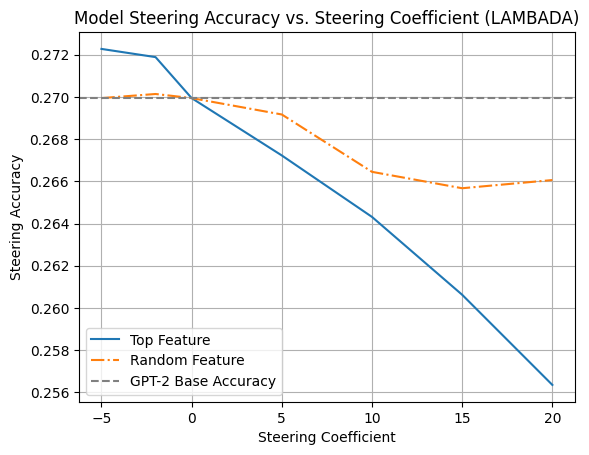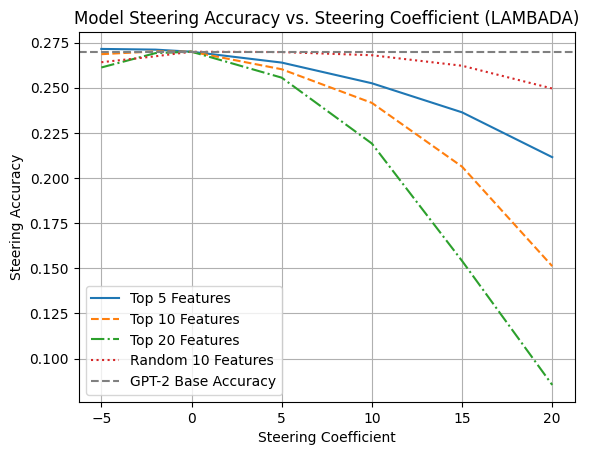

### Data Preparation

In [13]:
features_steered = 10
steer_coeff = 15.0

In [14]:
gpt2_accuracy, unsteered_data = calc_accuracy(lambada, model)
print('\n' + 'Accuracy: ' + str(gpt2_accuracy))

Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]


Accuracy: 0.2699398408693965


In [15]:
hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = steer_coeff)) for idx in top_feature_indices[:features_steered]]

with model.hooks(hooks):
  gpt2_accuracy, steered_data = calc_accuracy(lambada, model)
print('\n' + 'Accuracy: ' + str(gpt2_accuracy))

Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]


Accuracy: 0.2062875994566272


In [16]:
# Sort the unsteered and steered data with 2 metrics: (1) unsteered must succeed while steered failed, (2) sort based on failure severity
def sort_data(unsteered_data, steered_data):

  data = []
  for i in range(len(unsteered_data)):
    data.append({
        'unsteered': unsteered_data[i],
        'steered': steered_data[i]
    })

  differences = []
  for i in range(len(data)):
    item = data[i]

    if item['unsteered'][2] != 0 or item['steered'][2] == 0:
      diff = float('-inf')
    else:
      diff = item['steered'][2]

    differences.append((diff, i))

  # Sort in decreasing order of differences
  differences.sort(key=lambda x: -1 * x[0])

  sorted_data = []
  for i in range(len(differences)):
    sorted_data.append(steered_data[differences[i][1]])

  return sorted_data

In [17]:
data = sort_data(unsteered_data, steered_data)

### Single-Prompt Results

We now sample a prompt then run the base and steered model on it.

**Note**: The output will follow the following general form:

(1) Tokenized Prompt

(2) Tokenized Answer

(3) Top Ranking Tokens

(4) Ranks of the *correct* answer tokens

The model's intended output can thus be observed by looking at the top ranked token(s).  Note that if the answer has more than 1 token, then subsequent tokens may be influenced by the actual 1st answer token. Alternatively, you can observe how poorly the model performed by looking at the ranks of each of the actual/correct answer tokens the model assigns them.

In [18]:
chosen_index = 20
assert chosen_index >= 0 and chosen_index < len(lambada)

prompt, answer, _ = data[chosen_index]

print('Question: ' + prompt + '\n')
print('Answer: ' + answer)

Question: he flipped the calendar to november before muttering to himself , `` november has thanksgiving , and then december is christmas . no one wants to have to go to a wedding during the holidays . i think we should wait until after new year 's . what do you think about a january wedding ? '' he glanced over , his hand still holding the

Answer: calendar


**Base Model Output**:

In [19]:
utils.test_prompt(prompt, answer, model, print_details=True, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'he', ' flipped', ' the', ' calendar', ' to', ' no', 've', 'mber', ' before', ' mut', 'tering', ' to', ' himself', ' ,', ' ``', ' no', 've', 'mber', ' has', ' thanks', 'giving', ' ,', ' and', ' then', ' de', 'cember', ' is', ' christ', 'mas', ' .', ' no', ' one', ' wants', ' to', ' have', ' to', ' go', ' to', ' a', ' wedding', ' during', ' the', ' holidays', ' .', ' i', ' think', ' we', ' should', ' wait', ' until', ' after', ' new', ' year', " '", 's', ' .', ' what', ' do', ' you', ' think', ' about', ' a', ' jan', 'uary', ' wedding', ' ?', " ''", ' he', ' glanced', ' over', ' ,', ' his', ' hand', ' still', ' holding', ' the']
Tokenized answer: [' calendar']


Performance on answer token:
Rank: 0        Logit: 13.88 Prob: 12.24% Token: | calendar|

Top 0th token. Logit: 13.88 Prob: 12.24% Token: | calendar|
Top 1th token. Logit: 12.08 Prob:  2.03% Token: | scroll|
Top 2th token. Logit: 11.76 Prob:  1.47% Token: | clock|
Top 3th token. Logit: 11.55 Prob:  1.20% Token: | book|
Top 4th token. Logit: 11.51 Prob:  1.15% Token: | ring|
Top 5th token. Logit: 11.46 Prob:  1.10% Token: | door|
Top 6th token. Logit: 11.37 Prob:  1.00% Token: | paper|
Top 7th token. Logit: 11.37 Prob:  1.00% Token: | phone|
Top 8th token. Logit: 11.34 Prob:  0.97% Token: | knife|
Top 9th token. Logit: 11.17 Prob:  0.82% Token: | key|


Ranks of the answer tokens: [(' calendar', 0)]

**Hooked/Steered Model Output**:

In [20]:
hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = steer_coeff)) for idx in top_feature_indices[:features_steered]]
with model.hooks(hooks):
  utils.test_prompt(prompt, answer, model, print_details=True, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'he', ' flipped', ' the', ' calendar', ' to', ' no', 've', 'mber', ' before', ' mut', 'tering', ' to', ' himself', ' ,', ' ``', ' no', 've', 'mber', ' has', ' thanks', 'giving', ' ,', ' and', ' then', ' de', 'cember', ' is', ' christ', 'mas', ' .', ' no', ' one', ' wants', ' to', ' have', ' to', ' go', ' to', ' a', ' wedding', ' during', ' the', ' holidays', ' .', ' i', ' think', ' we', ' should', ' wait', ' until', ' after', ' new', ' year', " '", 's', ' .', ' what', ' do', ' you', ' think', ' about', ' a', ' jan', 'uary', ' wedding', ' ?', " ''", ' he', ' glanced', ' over', ' ,', ' his', ' hand', ' still', ' holding', ' the']
Tokenized answer: [' calendar']


Performance on answer token:
Rank: 41       Logit: 11.27 Prob:  0.42% Token: | calendar|

Top 0th token. Logit: 13.93 Prob:  5.99% Token: | blanket|
Top 1th token. Logit: 12.95 Prob:  2.25% Token: | dress|
Top 2th token. Logit: 12.89 Prob:  2.12% Token: | door|
Top 3th token. Logit: 12.76 Prob:  1.86% Token: | knife|
Top 4th token. Logit: 12.60 Prob:  1.59% Token: | phone|
Top 5th token. Logit: 12.39 Prob:  1.29% Token: | last|
Top 6th token. Logit: 12.35 Prob:  1.23% Token: | necklace|
Top 7th token. Logit: 12.25 Prob:  1.12% Token: | ring|
Top 8th token. Logit: 12.21 Prob:  1.07% Token: | hand|
Top 9th token. Logit: 12.20 Prob:  1.06% Token: | back|


Ranks of the answer tokens: [(' calendar', 41)]

### Top-k Prompt Results

In [21]:
top_k = 10

In [22]:
for idx in range(top_k):
  prompt, answer, _ = data[idx]

  line = '---------------------------------------------------------------------'

  print('\n' + 3 * line + '\n')
  print('Question: ' + prompt)
  print('Answer: ' + answer + '\n')

  print('Base Model...')
  utils.test_prompt(prompt, answer, model, print_details=True, prepend_bos=True)


  print('\nSteered Model...')
  hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = steer_coeff)) for idx in top_feature_indices[:features_steered]]
  with model.hooks(hooks):
    utils.test_prompt(prompt, answer, model, print_details=True, prepend_bos=True)


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: my eyes fly open , and i feel they 're engulfed in the ult l-e as i recite a poem as if someone else is controlling me , `` though the clouds darken the sun , and the rain becomes tainted , always know there will be a love that will not die . though hope seems a distant memory , and human machines walk the land , know no one can destroy a love that will not die . '' `` what are you babbling about ? '' the rogue asks . i surface from my unconscious state , and i sit up , stand , walk to the ppk , pick up the gun , and aim it for the
Answer: rogue

Base Model...
Tokenized prompt: ['<|endoftext|>', 'my', ' eyes', ' fly', ' open', ' ,', ' and', ' i', ' feel', ' they', " '", 're', ' engulfed', ' in', ' the', ' ult', ' l', '-', 'e', ' as', ' i', ' recite', ' a', ' poem', ' as

Performance on answer token:
Rank: 0        Logit: 10.92 Prob:  1.68% Token: | rogue|

Top 0th token. Logit: 10.92 Prob:  1.68% Token: | rogue|
Top 1th token. Logit: 10.75 Prob:  1.42% Token: | enemy|
Top 2th token. Logit: 10.49 Prob:  1.09% Token: | target|
Top 3th token. Logit: 10.40 Prob:  1.00% Token: | assassin|
Top 4th token. Logit: 10.36 Prob:  0.96% Token: | man|
Top 5th token. Logit: 10.31 Prob:  0.91% Token: | sniper|
Top 6th token. Logit: 10.31 Prob:  0.91% Token: | killer|
Top 7th token. Logit: 10.23 Prob:  0.85% Token: | other|
Top 8th token. Logit: 10.21 Prob:  0.82% Token: | next|
Top 9th token. Logit: 10.09 Prob:  0.73% Token: | first|


Ranks of the answer tokens: [(' rogue', 0)]


Steered Model...
Tokenized prompt: ['<|endoftext|>', 'my', ' eyes', ' fly', ' open', ' ,', ' and', ' i', ' feel', ' they', " '", 're', ' engulfed', ' in', ' the', ' ult', ' l', '-', 'e', ' as', ' i', ' recite', ' a', ' poem', ' as', ' if', ' someone', ' else', ' is', ' controlling', ' me', ' ,', ' ``', ' though', ' the', ' clouds', ' dark', 'en', ' the', ' sun', ' ,', ' and', ' the', ' rain', ' becomes', ' tainted', ' ,', ' always', ' know', ' there', ' will', ' be', ' a', ' love', ' that', ' will', ' not', ' die', ' .', ' though', ' hope', ' seems', ' a', ' distant', ' memory', ' ,', ' and', ' human', ' machines', ' walk', ' the', ' land', ' ,', ' know', ' no', ' one', ' can', ' destroy', ' a', ' love', ' that', ' will', ' not', ' die', ' .', " ''", ' ``', ' what', ' are', ' you', ' b', 'abbling', ' about', ' ?', " ''", ' the', ' rogue', ' asks', ' .', ' i', ' surface', ' from', ' my', ' unconscious', ' state', ' ,', ' and', ' i', ' sit', ' up', ' ,', ' stand', ' ,', ' walk', ' to', 

Performance on answer token:
Rank: 499      Logit:  7.73 Prob:  0.04% Token: | rogue|

Top 0th token. Logit: 11.88 Prob:  2.23% Token: | eyes|
Top 1th token. Logit: 11.58 Prob:  1.65% Token: | killer|
Top 2th token. Logit: 11.38 Prob:  1.36% Token: | last|
Top 3th token. Logit: 11.05 Prob:  0.98% Token: | red|
Top 4th token. Logit: 11.03 Prob:  0.96% Token: | white|
Top 5th token. Logit: 11.01 Prob:  0.94% Token: | girl|
Top 6th token. Logit: 10.96 Prob:  0.90% Token: | p|
Top 7th token. Logit: 10.87 Prob:  0.81% Token: | sky|
Top 8th token. Logit: 10.83 Prob:  0.79% Token: | other|
Top 9th token. Logit: 10.70 Prob:  0.69% Token: | man|


Ranks of the answer tokens: [(' rogue', 499)]


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: the director jumped up , went to a counter , handed over a ten , and brought back a plate of red velvet cakes . he put them in front of rusty , whose eyes widened with pleasure . she grabbed one in a napkin and began dunking it into her bowl of coffee . danish shook his head and grinned at the
Answer: director

Base Model...
Tokenized prompt: ['<|endoftext|>', 'the', ' director', ' jumped', ' up', ' ,', ' went', ' to', ' a', ' counter', ' ,', ' handed', ' over', ' a', ' ten', ' ,', ' and', ' brought', ' back', ' a', ' plate', ' of', ' red', ' velvet', ' cakes', ' .', ' he', ' put', ' them', ' in', ' front', ' of', ' rusty', ' ,', ' whose', ' eyes', ' widened', ' with', ' pleasure', ' .', ' she', ' grabbed', ' one', ' in', ' a', ' nap', 'kin', ' and', ' began', ' dunk', 

Performance on answer token:
Rank: 0        Logit: 13.11 Prob:  6.67% Token: | director|

Top 0th token. Logit: 13.11 Prob:  6.67% Token: | director|
Top 1th token. Logit: 12.17 Prob:  2.60% Token: | man|
Top 2th token. Logit: 12.02 Prob:  2.24% Token: | waitress|
Top 3th token. Logit: 11.93 Prob:  2.03% Token: | woman|
Top 4th token. Logit: 11.79 Prob:  1.78% Token: | two|
Top 5th token. Logit: 11.74 Prob:  1.69% Token: | chef|
Top 6th token. Logit: 11.74 Prob:  1.69% Token: | girl|
Top 7th token. Logit: 11.29 Prob:  1.08% Token: | waiter|
Top 8th token. Logit: 11.13 Prob:  0.91% Token: | other|
Top 9th token. Logit: 11.09 Prob:  0.88% Token: | scene|


Ranks of the answer tokens: [(' director', 0)]


Steered Model...
Tokenized prompt: ['<|endoftext|>', 'the', ' director', ' jumped', ' up', ' ,', ' went', ' to', ' a', ' counter', ' ,', ' handed', ' over', ' a', ' ten', ' ,', ' and', ' brought', ' back', ' a', ' plate', ' of', ' red', ' velvet', ' cakes', ' .', ' he', ' put', ' them', ' in', ' front', ' of', ' rusty', ' ,', ' whose', ' eyes', ' widened', ' with', ' pleasure', ' .', ' she', ' grabbed', ' one', ' in', ' a', ' nap', 'kin', ' and', ' began', ' dunk', 'ing', ' it', ' into', ' her', ' bowl', ' of', ' coffee', ' .', ' d', 'anish', ' shook', ' his', ' head', ' and', ' grinned', ' at', ' the']
Tokenized answer: [' director']


Performance on answer token:
Rank: 388      Logit:  8.91 Prob:  0.04% Token: | director|

Top 0th token. Logit: 13.53 Prob:  3.67% Token: | sight|
Top 1th token. Logit: 13.41 Prob:  3.24% Token: | red|
Top 2th token. Logit: 13.25 Prob:  2.76% Token: | look|
Top 3th token. Logit: 13.14 Prob:  2.48% Token: | girl|
Top 4th token. Logit: 13.00 Prob:  2.15% Token: | way|
Top 5th token. Logit: 12.70 Prob:  1.60% Token: | blonde|
Top 6th token. Logit: 12.66 Prob:  1.53% Token: | man|
Top 7th token. Logit: 12.64 Prob:  1.50% Token: | beautiful|
Top 8th token. Logit: 12.40 Prob:  1.19% Token: | woman|
Top 9th token. Logit: 12.36 Prob:  1.14% Token: | thought|


Ranks of the answer tokens: [(' director', 388)]


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: most of his audience was none too distant in age from the speaker himself , the youngest of them easily in his fifties . there was , of course , one exception : a young man standing near the back who scarcely could have been more than thirty , neatly dressed in a navy blue suit with a crimson tie . his thin spectacles sat below his eyes , balanced on the tip of his nose , and he peered over them directly at the
Answer: speaker

Base Model...
Tokenized prompt: ['<|endoftext|>', 'most', ' of', ' his', ' audience', ' was', ' none', ' too', ' distant', ' in', ' age', ' from', ' the', ' speaker', ' himself', ' ,', ' the', ' youngest', ' of', ' them', ' easily', ' in', ' his', ' f', 'ift', 'ies', ' .', ' there', ' was', ' ,', ' of', ' course', ' ,', ' one', ' exception', ' :'

Performance on answer token:
Rank: 0        Logit: 13.40 Prob: 12.78% Token: | speaker|

Top 0th token. Logit: 13.40 Prob: 12.78% Token: | speaker|
Top 1th token. Logit: 13.22 Prob: 10.67% Token: | audience|
Top 2th token. Logit: 12.13 Prob:  3.60% Token: | crowd|
Top 3th token. Logit: 11.97 Prob:  3.08% Token: | young|
Top 4th token. Logit: 11.68 Prob:  2.30% Token: | man|
Top 5th token. Logit: 10.97 Prob:  1.12% Token: | speakers|
Top 6th token. Logit: 10.89 Prob:  1.04% Token: | room|
Top 7th token. Logit: 10.63 Prob:  0.81% Token: | two|
Top 8th token. Logit: 10.57 Prob:  0.76% Token: | other|
Top 9th token. Logit: 10.29 Prob:  0.57% Token: | people|


Ranks of the answer tokens: [(' speaker', 0)]


Steered Model...
Tokenized prompt: ['<|endoftext|>', 'most', ' of', ' his', ' audience', ' was', ' none', ' too', ' distant', ' in', ' age', ' from', ' the', ' speaker', ' himself', ' ,', ' the', ' youngest', ' of', ' them', ' easily', ' in', ' his', ' f', 'ift', 'ies', ' .', ' there', ' was', ' ,', ' of', ' course', ' ,', ' one', ' exception', ' :', ' a', ' young', ' man', ' standing', ' near', ' the', ' back', ' who', ' scarcely', ' could', ' have', ' been', ' more', ' than', ' thirty', ' ,', ' neatly', ' dressed', ' in', ' a', ' navy', ' blue', ' suit', ' with', ' a', ' crimson', ' tie', ' .', ' his', ' thin', ' spect', 'acles', ' sat', ' below', ' his', ' eyes', ' ,', ' balanced', ' on', ' the', ' tip', ' of', ' his', ' nose', ' ,', ' and', ' he', ' pe', 'ered', ' over', ' them', ' directly', ' at', ' the']
Tokenized answer: [' speaker']


Performance on answer token:
Rank: 200      Logit:  8.82 Prob:  0.08% Token: | speaker|

Top 0th token. Logit: 12.20 Prob:  2.35% Token: | young|
Top 1th token. Logit: 12.04 Prob:  1.99% Token: | white|
Top 2th token. Logit: 11.90 Prob:  1.73% Token: | man|
Top 3th token. Logit: 11.79 Prob:  1.55% Token: | girl|
Top 4th token. Logit: 11.65 Prob:  1.35% Token: | woman|
Top 5th token. Logit: 11.64 Prob:  1.34% Token: | pale|
Top 6th token. Logit: 11.51 Prob:  1.17% Token: | ground|
Top 7th token. Logit: 11.34 Prob:  1.00% Token: | red|
Top 8th token. Logit: 11.31 Prob:  0.97% Token: | way|
Top 9th token. Logit: 11.24 Prob:  0.89% Token: | room|


Ranks of the answer tokens: [(' speaker', 200)]


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: chrissy was fully aware , however , that in the blink of an eye , the tripping of a small , red switch , she might suddenly cease to exist . si could see that awareness , that awful dilemma that her own end might be near , on her strained face . what would she decide ? he wondered . steeping closer towards him , chrissy moved his hand away from the
Answer: switch

Base Model...
Tokenized prompt: ['<|endoftext|>', 'ch', 'r', 'issy', ' was', ' fully', ' aware', ' ,', ' however', ' ,', ' that', ' in', ' the', ' blink', ' of', ' an', ' eye', ' ,', ' the', ' tri', 'pping', ' of', ' a', ' small', ' ,', ' red', ' switch', ' ,', ' she', ' might', ' suddenly', ' cease', ' to', ' exist', ' .', ' si', ' could', ' see', ' that', ' awareness', ' ,', ' that', ' awful', ' dilemma', ' 

Performance on answer token:
Rank: 0        Logit: 13.71 Prob: 12.66% Token: | switch|

Top 0th token. Logit: 13.71 Prob: 12.66% Token: | switch|
Top 1th token. Logit: 11.74 Prob:  1.77% Token: | small|
Top 2th token. Logit: 11.74 Prob:  1.76% Token: | edge|
Top 3th token. Logit: 11.31 Prob:  1.15% Token: | red|
Top 4th token. Logit: 11.10 Prob:  0.93% Token: | corner|
Top 5th token. Logit: 11.08 Prob:  0.91% Token: | door|
Top 6th token. Logit: 11.07 Prob:  0.91% Token: | handle|
Top 7th token. Logit: 11.01 Prob:  0.85% Token: | button|
Top 8th token. Logit: 11.00 Prob:  0.84% Token: | knob|
Top 9th token. Logit: 10.96 Prob:  0.81% Token: | end|


Ranks of the answer tokens: [(' switch', 0)]


Steered Model...
Tokenized prompt: ['<|endoftext|>', 'ch', 'r', 'issy', ' was', ' fully', ' aware', ' ,', ' however', ' ,', ' that', ' in', ' the', ' blink', ' of', ' an', ' eye', ' ,', ' the', ' tri', 'pping', ' of', ' a', ' small', ' ,', ' red', ' switch', ' ,', ' she', ' might', ' suddenly', ' cease', ' to', ' exist', ' .', ' si', ' could', ' see', ' that', ' awareness', ' ,', ' that', ' awful', ' dilemma', ' that', ' her', ' own', ' end', ' might', ' be', ' near', ' ,', ' on', ' her', ' strained', ' face', ' .', ' what', ' would', ' she', ' decide', ' ?', ' he', ' wondered', ' .', ' ste', 'eping', ' closer', ' towards', ' him', ' ,', ' ch', 'r', 'issy', ' moved', ' his', ' hand', ' away', ' from', ' the']
Tokenized answer: [' switch']


Performance on answer token:
Rank: 159      Logit:  9.83 Prob:  0.11% Token: | switch|

Top 0th token. Logit: 12.89 Prob:  2.43% Token: | red|
Top 1th token. Logit: 12.67 Prob:  1.96% Token: | kiss|
Top 2th token. Logit: 12.66 Prob:  1.93% Token: | side|
Top 3th token. Logit: 12.55 Prob:  1.73% Token: | corner|
Top 4th token. Logit: 12.48 Prob:  1.61% Token: | small|
Top 5th token. Logit: 12.37 Prob:  1.44% Token: | edge|
Top 6th token. Logit: 12.06 Prob:  1.06% Token: | hug|
Top 7th token. Logit: 12.04 Prob:  1.04% Token: | little|
Top 8th token. Logit: 11.85 Prob:  0.85% Token: | wall|
Top 9th token. Logit: 11.83 Prob:  0.84% Token: | soft|


Ranks of the answer tokens: [(' switch', 159)]


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: his voice was even less friendly than it had been the last time . `` i have every right to sit here should i choose to do so , '' she returned formally . she held out her bag of popcorn . `` here , '' she said . he frowned . `` i beg your pardon ? '' `` i 'm offering you some of my
Answer: popcorn

Base Model...
Tokenized prompt: ['<|endoftext|>', 'his', ' voice', ' was', ' even', ' less', ' friendly', ' than', ' it', ' had', ' been', ' the', ' last', ' time', ' .', ' ``', ' i', ' have', ' every', ' right', ' to', ' sit', ' here', ' should', ' i', ' choose', ' to', ' do', ' so', ' ,', " ''", ' she', ' returned', ' formally', ' .', ' she', ' held', ' out', ' her', ' bag', ' of', ' popcorn', ' .', ' ``', ' here', ' ,', " ''", ' she', ' said', ' .', ' he', ' frowned', ' .'

Performance on answer token:
Rank: 0        Logit: 13.65 Prob: 10.78% Token: | popcorn|

Top 0th token. Logit: 13.65 Prob: 10.78% Token: | popcorn|
Top 1th token. Logit: 13.58 Prob: 10.00% Token: | favorite|
Top 2th token. Logit: 13.19 Prob:  6.75% Token: | own|
Top 3th token. Logit: 12.71 Prob:  4.19% Token: | best|
Top 4th token. Logit: 12.12 Prob:  2.32% Token: | finest|
Top 5th token. Logit: 11.98 Prob:  2.03% Token: | fav|
Top 6th token. Logit: 11.73 Prob:  1.58% Token: | favourite|
Top 7th token. Logit: 11.71 Prob:  1.55% Token: | stuff|
Top 8th token. Logit: 11.65 Prob:  1.46% Token: | food|
Top 9th token. Logit: 11.46 Prob:  1.20% Token: | old|


Ranks of the answer tokens: [(' popcorn', 0)]


Steered Model...
Tokenized prompt: ['<|endoftext|>', 'his', ' voice', ' was', ' even', ' less', ' friendly', ' than', ' it', ' had', ' been', ' the', ' last', ' time', ' .', ' ``', ' i', ' have', ' every', ' right', ' to', ' sit', ' here', ' should', ' i', ' choose', ' to', ' do', ' so', ' ,', " ''", ' she', ' returned', ' formally', ' .', ' she', ' held', ' out', ' her', ' bag', ' of', ' popcorn', ' .', ' ``', ' here', ' ,', " ''", ' she', ' said', ' .', ' he', ' frowned', ' .', ' ``', ' i', ' beg', ' your', ' pardon', ' ?', " ''", ' ``', ' i', " '", 'm', ' offering', ' you', ' some', ' of', ' my']
Tokenized answer: [' popcorn']


Performance on answer token:
Rank: 118      Logit: 10.04 Prob:  0.10% Token: | popcorn|

Top 0th token. Logit: 14.75 Prob: 10.76% Token: | favorite|
Top 1th token. Logit: 14.50 Prob:  8.35% Token: | best|
Top 2th token. Logit: 13.98 Prob:  4.98% Token: | fav|
Top 3th token. Logit: 13.78 Prob:  4.05% Token: | love|
Top 4th token. Logit: 13.50 Prob:  3.06% Token: | own|
Top 5th token. Logit: 13.22 Prob:  2.32% Token: | favourite|
Top 6th token. Logit: 12.88 Prob:  1.65% Token: | clothes|
Top 7th token. Logit: 12.84 Prob:  1.59% Token: | stuff|
Top 8th token. Logit: 12.73 Prob:  1.43% Token: | things|
Top 9th token. Logit: 12.65 Prob:  1.32% Token: | finest|


Ranks of the answer tokens: [(' popcorn', 118)]


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: `` she 's always been fearless in her search for knowledge . '' alyssa explained , `` we 've read every book in the compound several times including the old set of encyclopedias we found in the attic . '' gabe 's smile vanished as he asked , `` i 'm surprised they allowed that . '' `` they did n't know , '' alyssa offered quietly , `` i was six years old when my parents brought me to the
Answer: compound

Base Model...
Tokenized prompt: ['<|endoftext|>', '``', ' she', " '", 's', ' always', ' been', ' fearless', ' in', ' her', ' search', ' for', ' knowledge', ' .', " ''", ' a', 'lyss', 'a', ' explained', ' ,', ' ``', ' we', " '", 've', ' read', ' every', ' book', ' in', ' the', ' compound', ' several', ' times', ' including', ' the', ' old', ' set', ' of', ' en', 'cycl',

Performance on answer token:
Rank: 0        Logit: 13.75 Prob: 18.83% Token: | compound|

Top 0th token. Logit: 13.75 Prob: 18.83% Token: | compound|
Top 1th token. Logit: 12.55 Prob:  5.66% Token: | house|
Top 2th token. Logit: 12.17 Prob:  3.85% Token: | school|
Top 3th token. Logit: 12.09 Prob:  3.56% Token: | library|
Top 4th token. Logit: 10.97 Prob:  1.16% Token: | place|
Top 5th token. Logit: 10.85 Prob:  1.04% Token: | farm|
Top 6th token. Logit: 10.84 Prob:  1.03% Token: | zoo|
Top 7th token. Logit: 10.51 Prob:  0.74% Token: | family|
Top 8th token. Logit: 10.51 Prob:  0.73% Token: | home|
Top 9th token. Logit: 10.43 Prob:  0.68% Token: | nursery|


Ranks of the answer tokens: [(' compound', 0)]


Steered Model...
Tokenized prompt: ['<|endoftext|>', '``', ' she', " '", 's', ' always', ' been', ' fearless', ' in', ' her', ' search', ' for', ' knowledge', ' .', " ''", ' a', 'lyss', 'a', ' explained', ' ,', ' ``', ' we', " '", 've', ' read', ' every', ' book', ' in', ' the', ' compound', ' several', ' times', ' including', ' the', ' old', ' set', ' of', ' en', 'cycl', 'oped', 'ias', ' we', ' found', ' in', ' the', ' attic', ' .', " ''", ' g', 'abe', " '", 's', ' smile', ' vanished', ' as', ' he', ' asked', ' ,', ' ``', ' i', " '", 'm', ' surprised', ' they', ' allowed', ' that', ' .', " ''", ' ``', ' they', ' did', ' n', "'t", ' know', ' ,', " ''", ' a', 'lyss', 'a', ' offered', ' quietly', ' ,', ' ``', ' i', ' was', ' six', ' years', ' old', ' when', ' my', ' parents', ' brought', ' me', ' to', ' the']
Tokenized answer: [' compound']


Performance on answer token:
Rank: 116      Logit:  8.99 Prob:  0.13% Token: | compound|

Top 0th token. Logit: 12.89 Prob:  6.66% Token: | house|
Top 1th token. Logit: 12.01 Prob:  2.77% Token: | library|
Top 2th token. Logit: 11.91 Prob:  2.50% Token: | nursery|
Top 3th token. Logit: 11.86 Prob:  2.39% Token: | place|
Top 4th token. Logit: 11.81 Prob:  2.26% Token: | school|
Top 5th token. Logit: 11.31 Prob:  1.37% Token: | little|
Top 6th token. Logit: 11.27 Prob:  1.32% Token: | hospital|
Top 7th token. Logit: 11.26 Prob:  1.30% Token: | world|
Top 8th token. Logit: 11.20 Prob:  1.23% Token: | room|
Top 9th token. Logit: 11.16 Prob:  1.19% Token: | door|


Ranks of the answer tokens: [(' compound', 116)]


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: `` the michalsons live a few houses down , and every summer they host a big backyard barbecue for the whole neighborhood . but i 'm sure everyone would understand if you 're too busy with the move , or just not interested . '' `` not interested ? '' marianne called out behind her . `` what kind of man is n't interested in a
Answer: barbecue

Base Model...
Tokenized prompt: ['<|endoftext|>', '``', ' the', ' m', 'ich', 'als', 'ons', ' live', ' a', ' few', ' houses', ' down', ' ,', ' and', ' every', ' summer', ' they', ' host', ' a', ' big', ' backyard', ' barbecue', ' for', ' the', ' whole', ' neighborhood', ' .', ' but', ' i', " '", 'm', ' sure', ' everyone', ' would', ' understand', ' if', ' you', " '", 're', ' too', ' busy', ' with', ' the', ' move', ' ,', ' or', ' jus

Performance on answer token:
Rank: 0        Logit: 12.99 Prob:  5.99% Token: | barbecue|

Top 0th token. Logit: 12.99 Prob:  5.99% Token: | barbecue|
Top 1th token. Logit: 12.86 Prob:  5.28% Token: | backyard|
Top 2th token. Logit: 12.81 Prob:  5.02% Token: | house|
Top 3th token. Logit: 12.65 Prob:  4.30% Token: | big|
Top 4th token. Logit: 12.16 Prob:  2.61% Token: | little|
Top 5th token. Logit: 12.10 Prob:  2.48% Token: | lot|
Top 6th token. Logit: 11.93 Prob:  2.09% Token: | place|
Top 7th token. Logit: 11.76 Prob:  1.75% Token: | family|
Top 8th token. Logit: 11.75 Prob:  1.74% Token: | new|
Top 9th token. Logit: 11.61 Prob:  1.52% Token: | move|


Ranks of the answer tokens: [(' barbecue', 0)]


Steered Model...
Tokenized prompt: ['<|endoftext|>', '``', ' the', ' m', 'ich', 'als', 'ons', ' live', ' a', ' few', ' houses', ' down', ' ,', ' and', ' every', ' summer', ' they', ' host', ' a', ' big', ' backyard', ' barbecue', ' for', ' the', ' whole', ' neighborhood', ' .', ' but', ' i', " '", 'm', ' sure', ' everyone', ' would', ' understand', ' if', ' you', " '", 're', ' too', ' busy', ' with', ' the', ' move', ' ,', ' or', ' just', ' not', ' interested', ' .', " ''", ' ``', ' not', ' interested', ' ?', " ''", ' mar', 'ian', 'ne', ' called', ' out', ' behind', ' her', ' .', ' ``', ' what', ' kind', ' of', ' man', ' is', ' n', "'t", ' interested', ' in', ' a']
Tokenized answer: [' barbecue']


Performance on answer token:
Rank: 107      Logit: 10.02 Prob:  0.15% Token: | barbecue|

Top 0th token. Logit: 13.83 Prob:  6.56% Token: | little|
Top 1th token. Logit: 13.79 Prob:  6.29% Token: | big|
Top 2th token. Logit: 12.88 Prob:  2.53% Token: | hug|
Top 3th token. Logit: 12.79 Prob:  2.31% Token: | good|
Top 4th token. Logit: 12.78 Prob:  2.30% Token: | new|
Top 5th token. Logit: 12.49 Prob:  1.72% Token: | house|
Top 6th token. Logit: 12.24 Prob:  1.34% Token: | lot|
Top 7th token. Logit: 12.23 Prob:  1.33% Token: | place|
Top 8th token. Logit: 12.09 Prob:  1.15% Token: | smile|
Top 9th token. Logit: 11.91 Prob:  0.96% Token: | life|


Ranks of the answer tokens: [(' barbecue', 107)]


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: ms. d'miagmo was that teacher . trystan opened his mouth , but brie cut him off , `` ms. d'miagmo , i think it 's obvious that trystan feels uncomfortable answering this question because of his religion . is n't it against school policy to discuss faith issues in the classroom anyway ? '' she flipped her golden hair over her shoulder and blinked her big blue eyes at the
Answer: teacher

Base Model...
Tokenized prompt: ['<|endoftext|>', 'ms', '.', ' d', "'m", 'i', 'ag', 'mo', ' was', ' that', ' teacher', ' .', ' try', 'stan', ' opened', ' his', ' mouth', ' ,', ' but', ' b', 'rie', ' cut', ' him', ' off', ' ,', ' ``', ' ms', '.', ' d', "'m", 'i', 'ag', 'mo', ' ,', ' i', ' think', ' it', " '", 's', ' obvious', ' that', ' try', 'stan', ' feels', ' uncomfortable', ' answerin

Performance on answer token:
Rank: 0        Logit: 13.43 Prob: 15.58% Token: | teacher|

Top 0th token. Logit: 13.43 Prob: 15.58% Token: | teacher|
Top 1th token. Logit: 11.66 Prob:  2.64% Token: | question|
Top 2th token. Logit: 11.59 Prob:  2.47% Token: | girl|
Top 3th token. Logit: 11.45 Prob:  2.14% Token: | student|
Top 4th token. Logit: 11.16 Prob:  1.61% Token: | students|
Top 5th token. Logit: 11.08 Prob:  1.48% Token: | other|
Top 6th token. Logit: 10.97 Prob:  1.34% Token: | two|
Top 7th token. Logit: 10.96 Prob:  1.32% Token: | professor|
Top 8th token. Logit: 10.89 Prob:  1.23% Token: | boy|
Top 9th token. Logit: 10.83 Prob:  1.15% Token: | class|


Ranks of the answer tokens: [(' teacher', 0)]


Steered Model...
Tokenized prompt: ['<|endoftext|>', 'ms', '.', ' d', "'m", 'i', 'ag', 'mo', ' was', ' that', ' teacher', ' .', ' try', 'stan', ' opened', ' his', ' mouth', ' ,', ' but', ' b', 'rie', ' cut', ' him', ' off', ' ,', ' ``', ' ms', '.', ' d', "'m", 'i', 'ag', 'mo', ' ,', ' i', ' think', ' it', " '", 's', ' obvious', ' that', ' try', 'stan', ' feels', ' uncomfortable', ' answering', ' this', ' question', ' because', ' of', ' his', ' religion', ' .', ' is', ' n', "'t", ' it', ' against', ' school', ' policy', ' to', ' discuss', ' faith', ' issues', ' in', ' the', ' classroom', ' anyway', ' ?', " ''", ' she', ' flipped', ' her', ' golden', ' hair', ' over', ' her', ' shoulder', ' and', ' blinked', ' her', ' big', ' blue', ' eyes', ' at', ' the']
Tokenized answer: [' teacher']


Performance on answer token:
Rank: 96       Logit: 10.07 Prob:  0.17% Token: | teacher|

Top 0th token. Logit: 12.96 Prob:  3.01% Token: | red|
Top 1th token. Logit: 12.90 Prob:  2.84% Token: | girl|
Top 2th token. Logit: 12.89 Prob:  2.81% Token: | words|
Top 3th token. Logit: 12.75 Prob:  2.45% Token: | thought|
Top 4th token. Logit: 12.56 Prob:  2.02% Token: | way|
Top 5th token. Logit: 12.47 Prob:  1.85% Token: | sight|
Top 6th token. Logit: 12.45 Prob:  1.81% Token: | look|
Top 7th token. Logit: 12.27 Prob:  1.51% Token: | sudden|
Top 8th token. Logit: 12.13 Prob:  1.32% Token: | question|
Top 9th token. Logit: 12.12 Prob:  1.30% Token: | white|


Ranks of the answer tokens: [(' teacher', 96)]


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: unfortunately , it was a short walk and no sooner had they gotten into a good stride in their conversation then they had arrived at the doorway to her biology class . `` i 'll see you tonight . how about six o’clock ? '' he asked . `` sounds great , '' she said , her face a little blushed as well . they said their goodbyes and jennifer disappeared into one of the
Answer: classrooms

Base Model...
Tokenized prompt: ['<|endoftext|>', 'un', 'fortunately', ' ,', ' it', ' was', ' a', ' short', ' walk', ' and', ' no', ' sooner', ' had', ' they', ' gotten', ' into', ' a', ' good', ' stride', ' in', ' their', ' conversation', ' then', ' they', ' had', ' arrived', ' at', ' the', ' doorway', ' to', ' her', ' biology', ' class', ' .', ' ``', ' i', " '", 'll', ' see', ' you', ' ton

Performance on answer token:
Rank: 0        Logit: 14.01 Prob:  7.17% Token: | classrooms|

Top 0th token. Logit: 14.01 Prob:  7.17% Token: | classrooms|
Top 1th token. Logit: 13.60 Prob:  4.74% Token: | rooms|
Top 2th token. Logit: 13.54 Prob:  4.48% Token: | hall|
Top 3th token. Logit: 13.32 Prob:  3.58% Token: | dorm|
Top 4th token. Logit: 13.15 Prob:  3.01% Token: | bedrooms|
Top 5th token. Logit: 12.71 Prob:  1.94% Token: | halls|
Top 6th token. Logit: 12.41 Prob:  1.43% Token: | back|
Top 7th token. Logit: 12.40 Prob:  1.43% Token: | living|
Top 8th token. Logit: 12.38 Prob:  1.39% Token: | hallway|
Top 9th token. Logit: 12.36 Prob:  1.37% Token: | chairs|


Ranks of the answer tokens: [(' classrooms', 0)]


Steered Model...
Tokenized prompt: ['<|endoftext|>', 'un', 'fortunately', ' ,', ' it', ' was', ' a', ' short', ' walk', ' and', ' no', ' sooner', ' had', ' they', ' gotten', ' into', ' a', ' good', ' stride', ' in', ' their', ' conversation', ' then', ' they', ' had', ' arrived', ' at', ' the', ' doorway', ' to', ' her', ' biology', ' class', ' .', ' ``', ' i', " '", 'll', ' see', ' you', ' tonight', ' .', ' how', ' about', ' six', ' o', '�', '�', 'clock', ' ?', " ''", ' he', ' asked', ' .', ' ``', ' sounds', ' great', ' ,', " ''", ' she', ' said', ' ,', ' her', ' face', ' a', ' little', ' bl', 'ushed', ' as', ' well', ' .', ' they', ' said', ' their', ' good', 'by', 'es', ' and', ' j', 'enn', 'ifer', ' disappeared', ' into', ' one', ' of', ' the']
Tokenized answer: [' classrooms']


Performance on answer token:
Rank: 95       Logit: 10.95 Prob:  0.20% Token: | classrooms|

Top 0th token. Logit: 13.43 Prob:  2.43% Token: | small|
Top 1th token. Logit: 13.19 Prob:  1.91% Token: | hall|
Top 2th token. Logit: 13.04 Prob:  1.65% Token: | dorm|
Top 3th token. Logit: 13.03 Prob:  1.63% Token: | many|
Top 4th token. Logit: 12.99 Prob:  1.57% Token: | little|
Top 5th token. Logit: 12.96 Prob:  1.53% Token: | room|
Top 6th token. Logit: 12.93 Prob:  1.47% Token: | white|
Top 7th token. Logit: 12.92 Prob:  1.47% Token: | rooms|
Top 8th token. Logit: 12.83 Prob:  1.33% Token: | back|
Top 9th token. Logit: 12.80 Prob:  1.30% Token: | corner|


Ranks of the answer tokens: [(' classrooms', 95)]


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: `` ah , ah , ah , mister , '' says madame pauline , her tone admonishing . `` off to the bathroom with you and change out of those clothes , right now ! '' i ca n't help but smirk at the treatment my uncle 's getting . `` it 's only a bit of mud , madame duguay , really . '' `` a bit of - you call that a bit of a
Answer: mud

Base Model...
Tokenized prompt: ['<|endoftext|>', '``', ' ah', ' ,', ' ah', ' ,', ' ah', ' ,', ' m', 'ister', ' ,', " ''", ' says', ' mad', 'ame', ' p', 'aul', 'ine', ' ,', ' her', ' tone', ' admon', 'ishing', ' .', ' ``', ' off', ' to', ' the', ' bathroom', ' with', ' you', ' and', ' change', ' out', ' of', ' those', ' clothes', ' ,', ' right', ' now', ' !', " ''", ' i', ' ca', ' n', "'t", ' help', ' but', ' sm', 'irk', ' at', ' the', ' treatment'

Performance on answer token:
Rank: 0        Logit: 12.17 Prob:  2.92% Token: | mud|

Top 0th token. Logit: 12.17 Prob:  2.92% Token: | mud|
Top 1th token. Logit: 11.59 Prob:  1.64% Token: | dirty|
Top 2th token. Logit: 11.46 Prob:  1.44% Token: | joke|
Top 3th token. Logit: 11.32 Prob:  1.26% Token: | m|
Top 4th token. Logit: 11.23 Prob:  1.14% Token: | bad|
Top 5th token. Logit: 11.03 Prob:  0.94% Token: | -|
Top 6th token. Logit: 11.01 Prob:  0.92% Token: | compliment|
Top 7th token. Logit: 10.99 Prob:  0.90% Token: | stink|
Top 8th token. Logit: 10.96 Prob:  0.88% Token: | slap|
Top 9th token. Logit: 10.95 Prob:  0.87% Token: | sm|


Ranks of the answer tokens: [(' mud', 0)]


Steered Model...
Tokenized prompt: ['<|endoftext|>', '``', ' ah', ' ,', ' ah', ' ,', ' ah', ' ,', ' m', 'ister', ' ,', " ''", ' says', ' mad', 'ame', ' p', 'aul', 'ine', ' ,', ' her', ' tone', ' admon', 'ishing', ' .', ' ``', ' off', ' to', ' the', ' bathroom', ' with', ' you', ' and', ' change', ' out', ' of', ' those', ' clothes', ' ,', ' right', ' now', ' !', " ''", ' i', ' ca', ' n', "'t", ' help', ' but', ' sm', 'irk', ' at', ' the', ' treatment', ' my', ' uncle', " '", 's', ' getting', ' .', ' ``', ' it', " '", 's', ' only', ' a', ' bit', ' of', ' mud', ' ,', ' mad', 'ame', ' dug', 'uay', ' ,', ' really', ' .', " ''", ' ``', ' a', ' bit', ' of', ' -', ' you', ' call', ' that', ' a', ' bit', ' of', ' a']
Tokenized answer: [' mud']


Performance on answer token:
Rank: 94       Logit: 10.60 Prob:  0.18% Token: | mud|

Top 0th token. Logit: 13.92 Prob:  5.11% Token: | tease|
Top 1th token. Logit: 13.42 Prob:  3.11% Token: | smile|
Top 2th token. Logit: 13.06 Prob:  2.17% Token: | blush|
Top 3th token. Logit: 13.06 Prob:  2.16% Token: | kiss|
Top 4th token. Logit: 12.79 Prob:  1.65% Token: | hug|
Top 5th token. Logit: 12.65 Prob:  1.44% Token: | dirty|
Top 6th token. Logit: 12.54 Prob:  1.28% Token: | bad|
Top 7th token. Logit: 12.49 Prob:  1.22% Token: | curse|
Top 8th token. Logit: 12.46 Prob:  1.19% Token: | slap|
Top 9th token. Logit: 12.45 Prob:  1.18% Token: | -|


Ranks of the answer tokens: [(' mud', 94)]

### Statistical Analysis

We first find the number of prompts that hallucinated (due to the structure of the cleaned data, once token_rank of data starts increasing that's indicative of reaching the end of hallucinating prompts).

In [23]:
num_hallucinated = 0
curr_lowest = float('inf')
for item in data:
  if item[2] <= curr_lowest:
    num_hallucinated += 1
    curr_lowest = item[2]
  else:
    break

print(num_hallucinated)

352


We now display sentence structural data to aid in our analysis

In [24]:
import string
from random import sample
from IPython.display import display

top_k = 10

def structural_stats(prompt):
  chars = prompt
  tokens = prompt.split()
  ends_with_article = prompt.strip().split()[-1].lower() in {"a", "an", "the"}

  return {
    "token_length": len(tokens),
    "comma_count": chars.count(","),
    "quote_count": chars.count("`") + chars.count("'"),
    "punct_ratio": sum(c in string.punctuation for c in chars) / len(chars),
    "ends_with_article": ends_with_article,
  }

# Top-k Hallucinations
drops = [prompt for prompt, _, _ in data[:top_k]]
drop_stats = [structural_stats(p) for p in drops]

# All Hallucinations
all_drops = [prompt for prompt, _, _ in data[:num_hallucinated]]
all_drop_stats = [structural_stats(p) for p in all_drops]

# Sample 100 random LAMBADA prompts
baseline = [prompt for prompt, _, _ in data]
base_stats = [structural_stats(p) for p in baseline]

# Compute averages and display table
df = pd.DataFrame(drop_stats + all_drop_stats + base_stats)
df['prompt_type'] = [f'Top {top_k} Hallucinating Prompts'] * len(drop_stats) + ['All Hallucinating Prompts'] * len(all_drop_stats) + ['LAMBADA'] * len(base_stats)
group_means = df.groupby('prompt_type').mean()

desired_order = ['LAMBADA', f'Top {top_k} Hallucinating Prompts', 'All Hallucinating Prompts']
group_means = group_means.reindex(desired_order)

display(group_means)

,token_length,comma_count,quote_count,punct_ratio,ends_with_article
prompt_type,,,,,
LAMBADA,72.720745,3.635940,9.467495,0.058767,0.273627
Top 10 Hallucinating Prompts,77.900000,5.100000,9.400000,0.052846,0.900000
All Hallucinating Prompts,73.008523,3.542614,8.735795,0.055464,0.605114
